In [1]:
import io
import re
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Semon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
trump_df = pd.read_csv('data/trump_prepared_tweets_transformer.csv', index_col='id')
trump_df.head()

,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V759,V760,V761,V762,V763,V764,V765,V766,V767,V768
id,,,,,,,,,,,,,,,,,,,,,
1234653427789070336,I was thrilled to be back in the Great city of...,2020-03-03,i was thrilled to be back in the great city of...,0.041417,-0.042731,0.006217,-0.067131,-0.014536,-0.020198,-0.037637,...,0.000968,-0.058070,-0.010195,-0.045221,-0.025572,-0.058799,-0.067292,-0.004863,-0.048326,-0.021921
1218010753434820608,RT @CBS_Herridge: READ: Letter to surveillance...,2020-01-17,rt read letter to surveillance court obtained ...,0.047121,0.012321,0.008286,-0.054554,0.031976,-0.011740,-0.063220,...,-0.006211,0.009399,-0.067262,-0.020455,-0.038795,-0.029703,-0.072416,0.035931,0.036871,0.038481
1304875170860015616,The Unsolicited Mail In Ballot Scam is a major...,2020-09-12,the unsolicited mail in ballot scam is a major...,-0.035107,0.001505,-0.007224,-0.015430,0.014132,0.044485,-0.048967,...,0.048927,-0.058868,-0.000800,-0.024277,-0.022527,-0.017610,0.020487,0.006837,-0.013474,0.061693
1218159531554897920,RT @MZHemingway: Very friendly telling of even...,2020-01-17,rt very friendly telling of events here about ...,0.016298,-0.068092,-0.004709,-0.085732,0.040950,-0.024538,-0.013751,...,0.028047,-0.003760,-0.032635,0.037088,-0.001459,0.018904,-0.076467,0.007178,-0.012850,0.008524
1217962723234983936,RT @WhiteHouse: President @realDonaldTrump ann...,2020-01-17,rt president announced historic steps to prote...,0.007337,-0.059023,0.021116,-0.036806,0.004089,-0.016398,-0.053553,...,0.046635,0.053444,0.002423,-0.042410,0.017107,-0.038225,-0.016442,-0.031505,0.020988,0.019220


In [4]:
trump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18649 entries, 1234653427789070336 to 1319345719829008384
Columns: 771 entries, text to V768
dtypes: float64(768), object(3)
memory usage: 109.8+ MB


In [5]:
text_embeddings = trump_df[filter(lambda c: c.startswith('V'), trump_df.columns)]
text_embeddings.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V759,V760,V761,V762,V763,V764,V765,V766,V767,V768
id,,,,,,,,,,,,,,,,,,,,,
1234653427789070336,0.041417,-0.042731,0.006217,-0.067131,-0.014536,-0.020198,-0.037637,-0.030301,0.032346,-0.034122,...,0.000968,-0.058070,-0.010195,-0.045221,-0.025572,-0.058799,-0.067292,-0.004863,-0.048326,-0.021921
1218010753434820608,0.047121,0.012321,0.008286,-0.054554,0.031976,-0.011740,-0.063220,0.006682,-0.025631,-0.037964,...,-0.006211,0.009399,-0.067262,-0.020455,-0.038795,-0.029703,-0.072416,0.035931,0.036871,0.038481
1304875170860015616,-0.035107,0.001505,-0.007224,-0.015430,0.014132,0.044485,-0.048967,-0.067114,0.061533,-0.047387,...,0.048927,-0.058868,-0.000800,-0.024277,-0.022527,-0.017610,0.020487,0.006837,-0.013474,0.061693
1218159531554897920,0.016298,-0.068092,-0.004709,-0.085732,0.040950,-0.024538,-0.013751,0.023894,-0.037537,-0.016767,...,0.028047,-0.003760,-0.032635,0.037088,-0.001459,0.018904,-0.076467,0.007178,-0.012850,0.008524
1217962723234983936,0.007337,-0.059023,0.021116,-0.036806,0.004089,-0.016398,-0.053553,-0.064944,-0.014160,0.030843,...,0.046635,0.053444,0.002423,-0.042410,0.017107,-0.038225,-0.016442,-0.031505,0.020988,0.019220


In [6]:
%%time
pca = PCA(n_components=2, random_state=42)
text_pca = pca.fit_transform(text_embeddings)
print('PCA done!')

umap = UMAP(n_components=2, n_jobs=-1, random_state=42)
text_umap = umap.fit_transform(text_embeddings)
print('UMAP done!')

umap_cosine = UMAP(n_components=2, n_jobs=-1, metric='cosine', random_state=42)
text_umap_cosine = umap_cosine.fit_transform(text_embeddings)
print('UMAP(cosine) done!')

PCA done!
UMAP done!
UMAP(cosine) done!
CPU times: total: 1min 40s
Wall time: 1min 13s


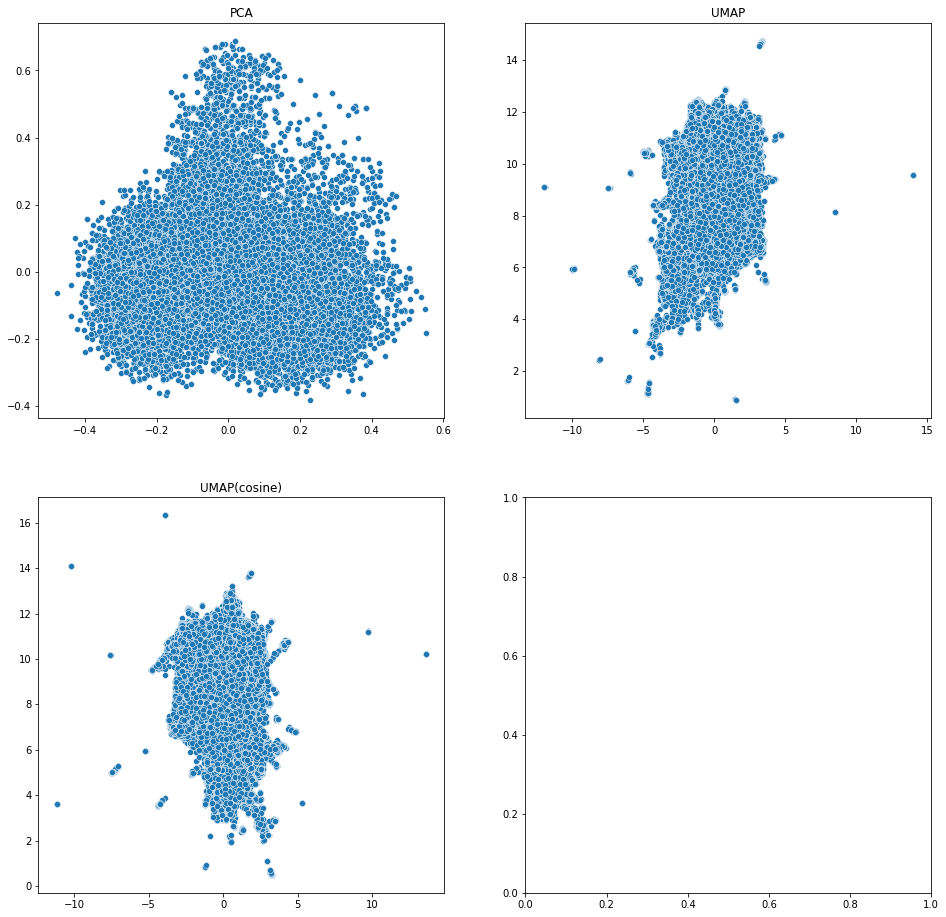

In [7]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21);

In [8]:
K = list(range(1, 16))

inertia = {}
silhouette = {}

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(text_embeddings)
    inertia[k] = kmeans.inertia_
    silhouette[k] = silhouette_score(text_embeddings, kmeans.labels_) if k > 1 else None

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [04:55<00:00, 19.69s/it]


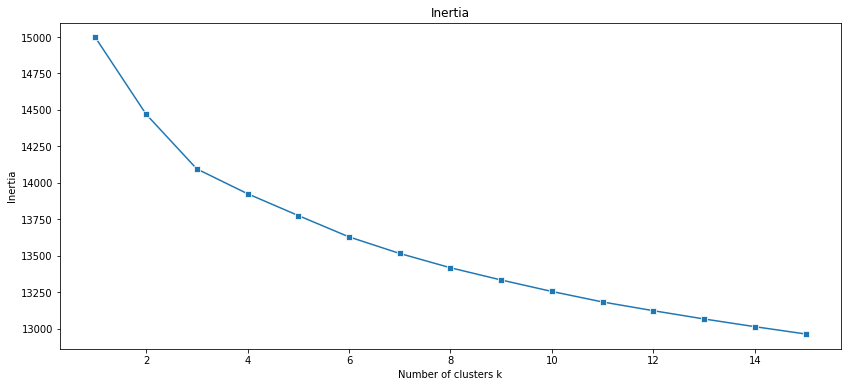

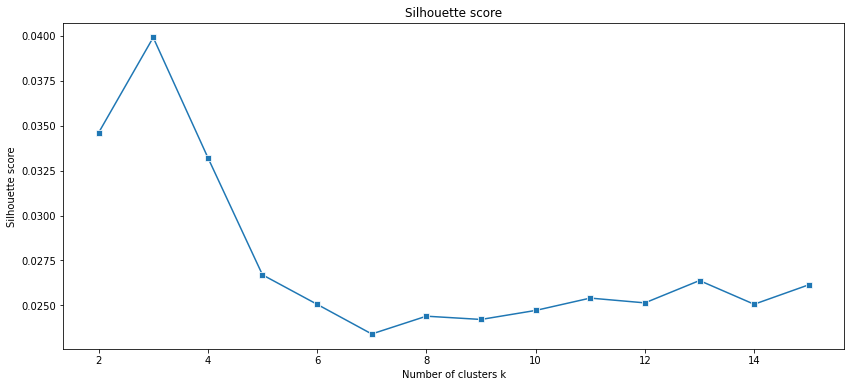

In [9]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[inertia[k] for k in K], marker='s')

plt.title('Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [10]:
d = {}
for k in K[1:-1]:
    d[k] = (inertia[k] - inertia[k + 1]) / (inertia[k - 1] - inertia[k])

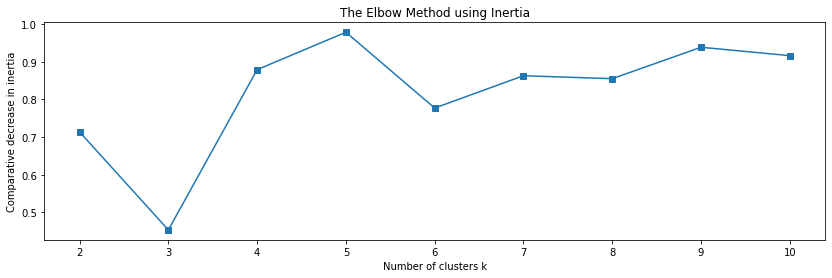

In [11]:
plt.figure(figsize=(14, 4))
plt.plot(list(d.keys())[:9], list(d.values())[:9], marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

In [12]:
kmeans = KMeans(
    n_clusters=3,
    # eps=0.6,
    # metric='cosine',
    random_state=42
)
clusters = kmeans.fit_predict(text_embeddings)
# clusters = kmeans.fit_predict(text_pca)
print(len(set(clusters)))

3


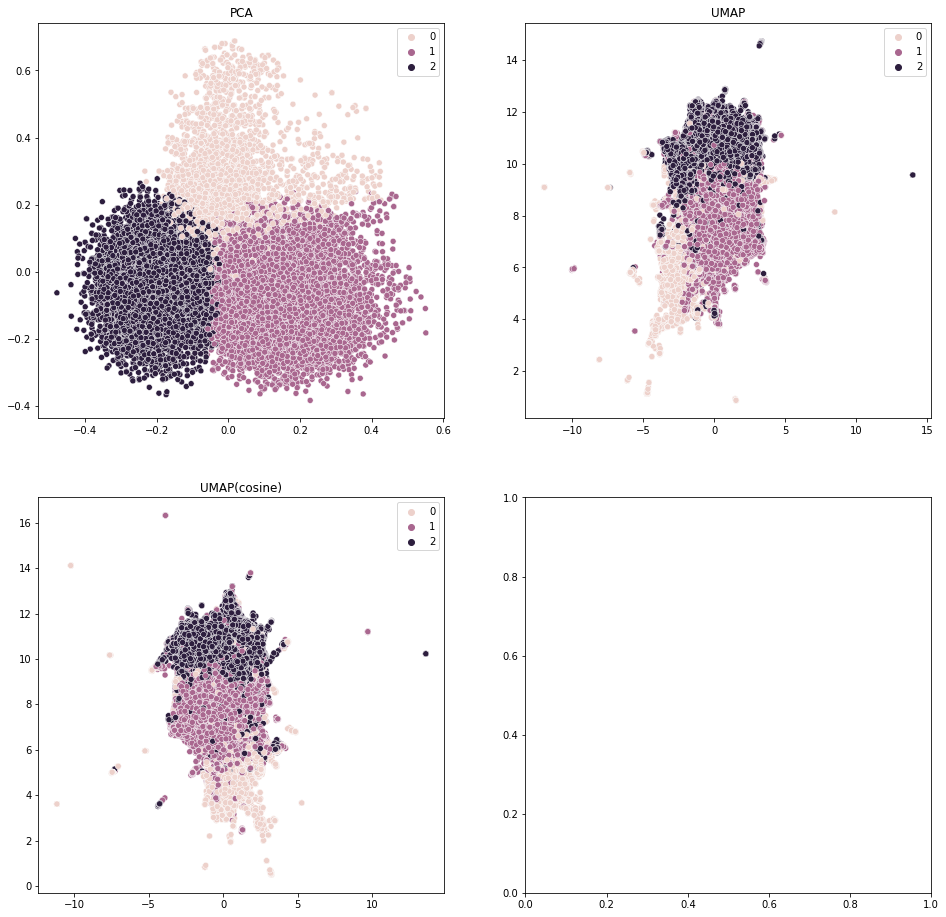

In [13]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=clusters);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=clusters);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=clusters);

In [14]:
def print_top_n_words(data: pd.Series, n: int = 25):
    words_counter = collections.Counter()
    data.str.split().apply(lambda l: [v for v in l if v not in stop_words]).apply(words_counter.update)
    return words_counter.most_common(n)

In [15]:
trump_df['cluster'] = clusters
trump_df.groupby('cluster')['cluster'].count()

cluster
0    3141
1    8914
2    6594
Name: cluster, dtype: int64

In [16]:
for cluster in set(trump_df['cluster']):
    print(
        f'Cluster {cluster:3}. {len(trump_df.query(f"cluster == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(trump_df.query(f'cluster == {cluster}').cleared_text, n=10)
    )

Cluster   0.  3141 tweets total. Top-3 words: [('thank', 726), ('great', 629), ('maga', 145), ('america', 134), ('big', 118), ('news', 115), ('see', 95), ('p', 90), ('congratulations', 88), ('make', 78)]
Cluster   1.  8914 tweets total. Top-3 words: [('president', 1559), ('trump', 1299), ('democrats', 631), ('biden', 579), ('people', 420), ('today', 407), ('impeachment', 401), ('american', 390), ('new', 384), ('america', 337)]
Cluster   2.  6594 tweets total. Top-3 words: [('great', 1546), ('people', 1042), ('amp', 856), ('president', 829), ('democrats', 722), ('country', 719), ('news', 662), ('big', 661), ('fake', 660), ('would', 646)]


In [17]:
cluster = 0

print(print_top_n_words(trump_df.query(f'cluster == {cluster}').text))
trump_df.query(f'cluster == {cluster}').head(10)

[('Thank', 532), ('RT', 412), ('great', 212), ('I', 207), ('Great', 195), ('you!', 176), ('THANK', 157), ('A', 139), ('#MAGA', 125), ('GREAT', 124), ('The', 110), ('YOU', 107), ('@realDonaldTrump:', 105), ('AMERICA', 95), ('THE', 78), ('P.M.', 77), ('We', 71), ('MAKE', 69), ('So', 65), ('Congratulations', 64), ('AGAIN!', 61), ('Will', 56), ('Enjoy!', 55), ('See', 54), ('&', 52)]


,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V760,V761,V762,V763,V764,V765,V766,V767,V768,cluster
id,,,,,,,,,,,,,,,,,,,,,
1223640662689689600,Getting a little exercise this morning! https:...,2020-02-01,getting a little exercise this morning,0.026586,-0.012881,-0.025082,-0.057336,-0.048045,-0.053242,-0.025420,...,-0.009627,-0.030222,-0.039215,-0.033056,-0.011107,-0.020141,-0.058766,-0.000594,-0.029212,0
1215247978966986752,Thank you Elise! https://t.co/Y4Hb0zf5jk,2020-01-09,thank you elise,-0.007193,-0.054833,0.044282,-0.068457,0.038491,0.033073,-0.052286,...,-0.010526,0.045627,-0.047504,-0.017094,-0.008489,-0.065921,0.020771,0.021009,0.042735,0
1319491234042269696,"As per your request, Joe... https://t.co/78mzc...",2020-10-23,as per your request joe,0.033866,-0.039781,0.015193,-0.063052,0.022289,-0.056880,-0.059863,...,-0.019065,0.031768,0.018654,0.010955,-0.014422,-0.018988,-0.028264,-0.037383,0.039835,0
1319655865083940864,Thank you Megyn! https://t.co/sC71EEWIOd,2020-10-23,thank you megyn,-0.011979,-0.027580,0.050801,-0.064919,0.021094,0.050830,-0.023577,...,-0.005426,0.045730,-0.003621,-0.004183,-0.012279,-0.041208,-0.031152,0.018036,0.035972,0
1319510534098735104,11 DAYS! #MAGA https://t.co/PuqeF1ctDs,2020-10-23,11 days maga,-0.051946,0.031102,0.046327,-0.062508,0.007215,-0.008960,-0.026832,...,-0.035392,-0.032970,-0.067617,-0.008262,0.051450,-0.035768,-0.046331,0.012496,0.001403,0
1325891490636320768,Wisconsin is looking very good. Needs a little...,2020-11-09,wisconsin is looking very good needs a little ...,-0.023682,-0.075263,-0.038456,-0.002422,-0.069970,-0.017925,-0.017329,...,0.047575,-0.044376,-0.017128,0.012545,-0.004819,-0.026588,-0.011656,0.029058,-0.014612,0
1320096006038380288,Just landed in Ohio. See you in a little while!,2020-10-24,just landed in ohio see you in a little while,-0.064166,-0.046319,-0.041295,-0.083195,0.009405,-0.054693,0.000968,...,0.042904,-0.036780,0.045673,-0.031367,-0.035987,-0.024015,-0.046652,-0.068466,-0.054977,0
1346105727488765952,RT @realDonaldTrump: I will be there. Historic...,2021-01-04,rt i will be there historic day,-0.031701,-0.063058,-0.004818,-0.060146,-0.042645,0.019873,-0.012024,...,-0.019469,-0.063408,-0.062056,-0.033643,-0.059009,-0.011283,0.036293,-0.063941,-0.045966,0
1320134156035174400,THANK YOU OHIO! #VOTE \nhttps://t.co/5EJjFZVLHZ,2020-10-24,thank you ohio vote,-0.038665,-0.023050,-0.001816,-0.069952,0.043907,-0.022069,-0.015169,...,-0.041089,0.033876,0.023314,-0.047030,-0.050340,-0.066321,0.020123,-0.048759,0.005346,0


In [18]:
EPS = np.linspace(0.01, 10., 100)

silhouette = {}
clusters = {}

for eps in tqdm(EPS):
    dbscan = DBSCAN(eps=eps, n_jobs=-1).fit(text_embeddings) # metric='cosine' checked
    clusters[eps] = len(set(dbscan.labels_)) - 1
    # print(set(dbscan.labels_))
    if len(set(dbscan.labels_)) > 1:
        # print(eps, set(dbscan.labels_))
        silhouette[eps] = silhouette_score(text_embeddings, dbscan.labels_)
# print(silhouette

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [25:29<00:00, 15.30s/it]


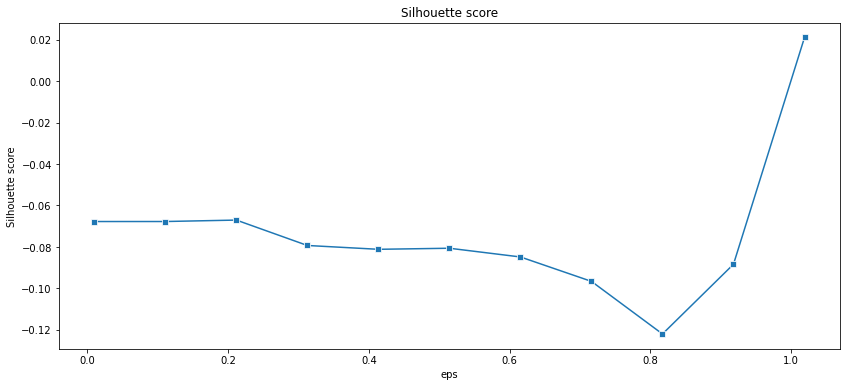

In [19]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[silhouette.get(eps) for eps in EPS], marker='s')

plt.title('Silhouette score')
plt.xlabel('eps')
plt.ylabel('Silhouette score')

plt.show()

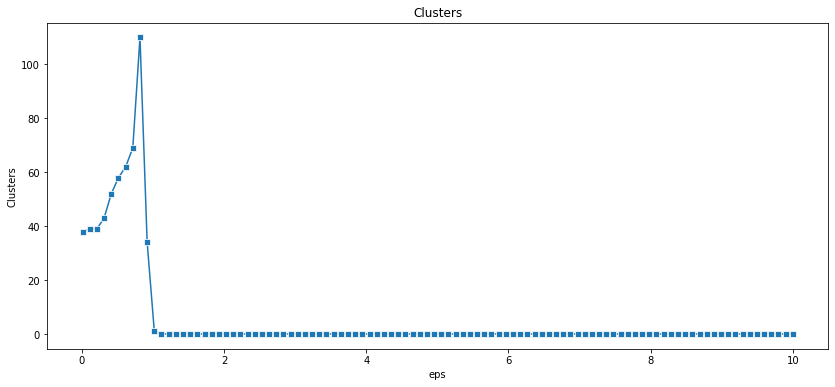

In [20]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[clusters.get(eps) for eps in EPS], marker='s')

plt.title('Clusters')
plt.xlabel('eps')
plt.ylabel('Clusters')

plt.show()

In [21]:
best_eps = [*silhouette.keys()][np.argmax([*silhouette.values()])]
# best_eps = max({eps for eps, c in clusters.items() if c == 3})
best_eps, clusters.get(best_eps)

(1.019090909090909, 1)

In [22]:
dbscan = DBSCAN(eps=best_eps, n_jobs=-1) # metric='cosine' checked
trump_df['cluster_dbscan'] = dbscan.fit_predict(text_embeddings)

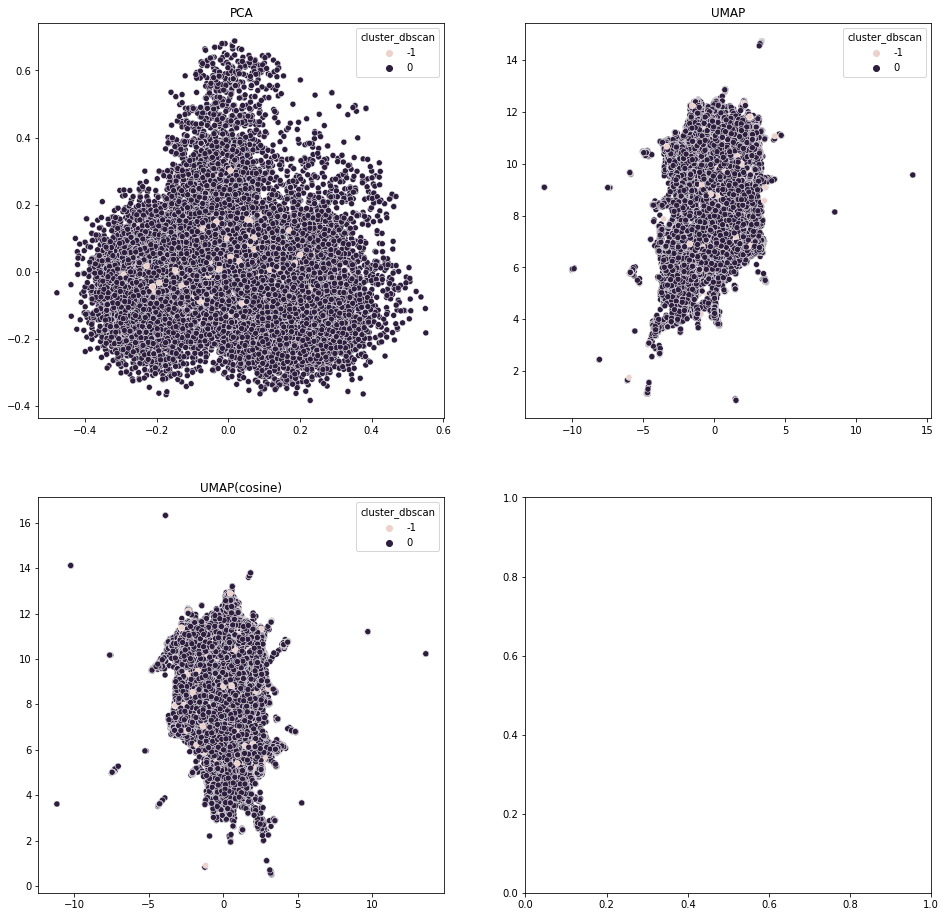

In [23]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=trump_df['cluster_dbscan']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=trump_df['cluster_dbscan']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=trump_df['cluster_dbscan']);

In [24]:
trump_df.groupby('cluster_dbscan')['cluster_dbscan'].count()

cluster_dbscan
-1      295
 0    18354
Name: cluster_dbscan, dtype: int64

In [25]:
for cluster in set(trump_df['cluster_dbscan']):
    print(
        f'Cluster {cluster:3}. {len(trump_df.query(f"cluster_dbscan == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(trump_df.query(f'cluster_dbscan == {cluster}').cleared_text, n=3)
    )

Cluster   0. 18354 tweets total. Top-3 words: [('great', 2458), ('president', 2417), ('trump', 1819)]
Cluster  -1.   295 tweets total. Top-3 words: [('great', 19), ('like', 18), ('people', 16)]


In [26]:
cluster = -1

print(print_top_n_words(trump_df.query(f'cluster_dbscan == {cluster}').text))
trump_df.query(f'cluster_dbscan == {cluster}').head(10)

[('RT', 110), ('I', 36), ('The', 32), ('&', 24), ('A', 16), ('like', 14), ('-', 13), ('get', 13), ('would', 13), ('Joe', 12), ('This', 11), ('people', 11), ('&amp,', 11), ('Biden', 10), ('They', 9), ('got', 9), ('U.S.', 9), ('It', 9), ('good', 9), ('If', 9), ('He', 8), ('New', 8), ('Trump', 8), ('Not', 8), ('United', 8)]


,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V761,V762,V763,V764,V765,V766,V767,V768,cluster,cluster_dbscan
id,,,,,,,,,,,,,,,,,,,,,
1325922164676104192,RT @ChanelRion: #Developing: The #DominionVoti...,2020-11-09,rt developing the dominionvotingsystems that g...,0.034675,0.005490,0.030891,0.023291,-0.004698,-0.033768,-0.005024,...,0.006716,0.012230,-0.026789,0.016819,0.037073,0.026592,0.008962,0.051369,1,-1
1328330461211488512,RT @RudyGiuliani: I imagine this guy has a rea...,2020-11-16,rt i imagine this guy has a reading deficit he...,-0.013780,0.057020,0.015538,-0.028507,-0.033678,-0.003206,-0.073105,...,-0.009797,0.002357,-0.005070,-0.029967,-0.025182,-0.015722,0.035956,-0.027824,1,-1
1346533549013409792,RT @jmclghln: @realDonaldTrump voters across t...,2021-01-05,rt voters across the usa if you have friends o...,0.048976,-0.057753,-0.053453,-0.039188,-0.001292,-0.005474,0.034867,...,-0.035948,-0.011502,-0.036104,-0.012825,0.016523,-0.039536,-0.060542,0.016645,1,-1
1332155514386599936,A must read. Impossible for Biden to have over...,2020-11-27,a must read impossible for biden to have overc...,-0.008150,0.047518,-0.024606,-0.012843,0.007723,0.055277,-0.015051,...,0.001983,-0.025828,-0.008224,0.042757,-0.028757,-0.003948,0.040957,-0.042143,2,-1
1326343694912466944,That’s why Mike was number one in his class at...,2020-11-11,that s why mike was number one in his class at...,-0.008187,0.023189,-0.061938,-0.065436,-0.012717,0.022867,-0.054263,...,0.024045,-0.004923,-0.048408,-0.011899,0.027670,-0.007392,-0.062546,-0.002823,0,-1
1332462484582707200,RT @SenMastriano: This was posted on our Depar...,2020-11-27,rt this was posted on our department of state ...,0.023692,0.025398,0.016719,-0.040891,-0.027596,0.016738,-0.016005,...,-0.062553,-0.030542,0.049145,0.041055,0.044489,0.056953,0.008463,-0.014643,1,-1
1320490697766637568,Biden dumped New Hampshire in the Dem Primarie...,2020-10-25,biden dumped new hampshire in the dem primarie...,0.017780,0.061458,-0.009851,-0.026148,-0.018781,0.055941,-0.053232,...,0.013957,0.004719,0.021854,-0.001334,0.025833,-0.011025,-0.028381,0.008598,2,-1
1319046134317371392,Multiple Pro-Trump Demonstrations Planned in C...,2020-10-21,multiple pro trump demonstrations planned in c...,0.058626,0.008246,-0.012261,-0.019935,-0.015610,-0.018877,0.026758,...,-0.058371,0.036905,-0.041648,0.009711,0.006386,-0.001265,0.052244,-0.017843,1,-1
1333458950038106112,Trump legal team in Arizona and on @OANN now. ...,2020-11-30,trump legal team in arizona and on now big stu...,0.027369,0.004797,-0.026118,0.007404,0.035582,-0.002281,0.026060,...,-0.018107,-0.046898,-0.038220,-0.045419,-0.045266,0.045387,0.011198,-0.020509,1,-1


In [28]:
K = list(range(2, 26))

silhouette = {}

for k in tqdm(K):
    aggl = AgglomerativeClustering(n_clusters=k).fit(text_embeddings)
    silhouette[k] = silhouette_score(text_embeddings, aggl.labels_) if k > 1 else None

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [54:09<00:00, 135.39s/it]


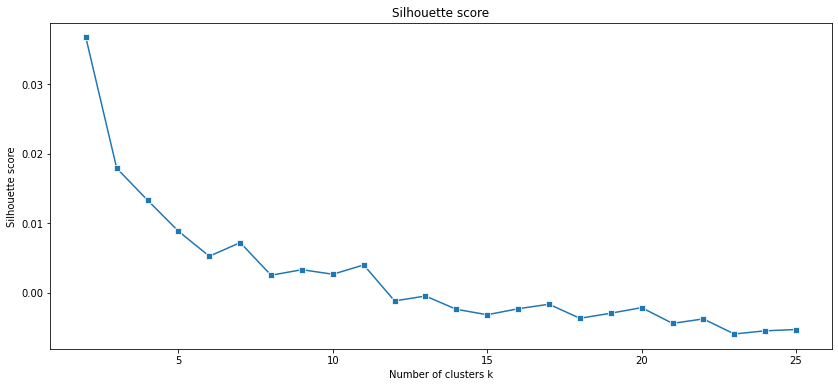

In [29]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [30]:
best_k = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_k

2

In [31]:
%%time
agglomerative = AgglomerativeClustering(n_clusters=best_k)
trump_df['cluster_agglom'] = agglomerative.fit_predict(text_embeddings)

CPU times: total: 2min 11s
Wall time: 2min 12s


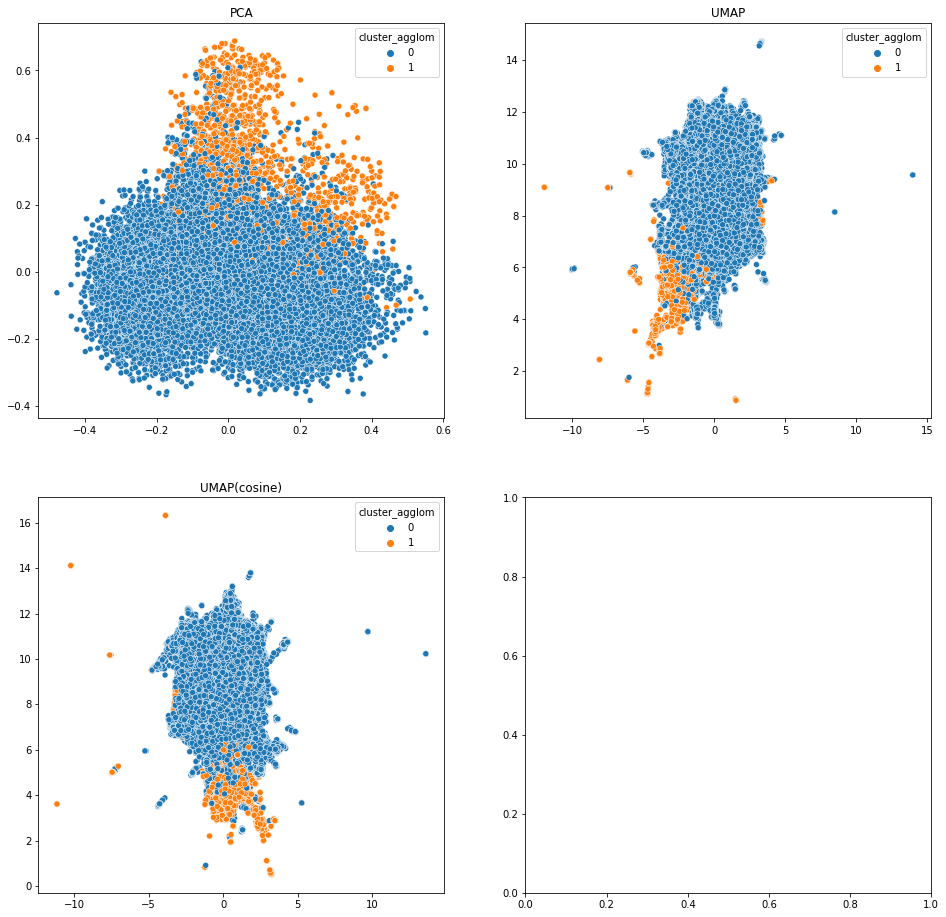

In [32]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=trump_df['cluster_agglom']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=trump_df['cluster_agglom']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=trump_df['cluster_agglom']);

In [33]:
trump_df.groupby('cluster_agglom')['cluster_agglom'].count()

cluster_agglom
0    16864
1     1785
Name: cluster_agglom, dtype: int64

In [34]:
for cluster in set(trump_df['cluster_agglom']):
    print(
        f'Cluster {cluster:3}. {len(trump_df.query(f"cluster_agglom == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(trump_df.query(f'cluster_agglom == {cluster}').cleared_text, n=3)
    )

Cluster   0. 16864 tweets total. Top-3 words: [('president', 2417), ('great', 2182), ('trump', 1821)]
Cluster   1.  1785 tweets total. Top-3 words: [('thank', 479), ('great', 295), ('maga', 74)]


In [36]:
cluster = 1

print('Entries:', len(trump_df.query(f'cluster_agglom == {cluster}')))
print(print_top_n_words(trump_df.query(f'cluster_agglom == {cluster}').text))
trump_df.query(f'cluster_agglom == {cluster}').head(10)#.text.apply(text_preprocessor)

Entries: 1785
[('RT', 468), ('Thank', 357), ('@realDonaldTrump:', 107), ('THANK', 100), ('you!', 90), ('Great', 87), ('great', 87), ('I', 77), ('#MAGA', 67), ('GREAT', 67), ('AMERICA', 62), ('YOU', 55), ('A', 54), ('So', 48), ('MAKE', 47), ('AGAIN!', 46), ('THE', 44), ('We', 40), ('YOU!', 38), ('The', 36), ('&', 33), ('This', 30), ('job', 26), ('Great!', 24), ('never', 24)]


,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V762,V763,V764,V765,V766,V767,V768,cluster,cluster_dbscan,cluster_agglom
id,,,,,,,,,,,,,,,,,,,,,
1223640662689689600,Getting a little exercise this morning! https:...,2020-02-01,getting a little exercise this morning,0.026586,-0.012881,-0.025082,-0.057336,-0.048045,-0.053242,-0.025420,...,-0.039215,-0.033056,-0.011107,-0.020141,-0.058766,-0.000594,-0.029212,0,0,1
1215247978966986752,Thank you Elise! https://t.co/Y4Hb0zf5jk,2020-01-09,thank you elise,-0.007193,-0.054833,0.044282,-0.068457,0.038491,0.033073,-0.052286,...,-0.047504,-0.017094,-0.008489,-0.065921,0.020771,0.021009,0.042735,0,0,1
1319491234042269696,"As per your request, Joe... https://t.co/78mzc...",2020-10-23,as per your request joe,0.033866,-0.039781,0.015193,-0.063052,0.022289,-0.056880,-0.059863,...,0.018654,0.010955,-0.014422,-0.018988,-0.028264,-0.037383,0.039835,0,0,1
1319655865083940864,Thank you Megyn! https://t.co/sC71EEWIOd,2020-10-23,thank you megyn,-0.011979,-0.027580,0.050801,-0.064919,0.021094,0.050830,-0.023577,...,-0.003621,-0.004183,-0.012279,-0.041208,-0.031152,0.018036,0.035972,0,0,1
1319510534098735104,11 DAYS! #MAGA https://t.co/PuqeF1ctDs,2020-10-23,11 days maga,-0.051946,0.031102,0.046327,-0.062508,0.007215,-0.008960,-0.026832,...,-0.067617,-0.008262,0.051450,-0.035768,-0.046331,0.012496,0.001403,0,0,1
1346105727488765952,RT @realDonaldTrump: I will be there. Historic...,2021-01-04,rt i will be there historic day,-0.031701,-0.063058,-0.004818,-0.060146,-0.042645,0.019873,-0.012024,...,-0.062056,-0.033643,-0.059009,-0.011283,0.036293,-0.063941,-0.045966,0,0,1
1320134156035174400,THANK YOU OHIO! #VOTE \nhttps://t.co/5EJjFZVLHZ,2020-10-24,thank you ohio vote,-0.038665,-0.023050,-0.001816,-0.069952,0.043907,-0.022069,-0.015169,...,0.023314,-0.047030,-0.050340,-0.066321,0.020123,-0.048759,0.005346,0,0,1
1317060388371025920,Thank you! https://t.co/ceq1n14MYa,2020-10-16,thank you,-0.011170,-0.051739,0.030005,-0.070321,0.053635,-0.019353,-0.003185,...,-0.018133,-0.035292,0.016747,-0.062255,-0.004840,0.012121,0.042987,0,0,1
1317057909927325696,Thank you LIBERTARIANS. We are getting it all ...,2020-10-16,thank you libertarians we are getting it all d...,0.033130,-0.027457,-0.009690,0.008615,-0.020900,0.014124,0.019775,...,-0.010247,-0.064371,0.017704,-0.076629,0.016388,0.058354,0.011925,2,0,1
